In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
import matplotlib.pyplot as plt

# Importation des valeurs

In [3]:
alpha = 0.15
b = 1
sigma = 0.2
T = 1
r = 0.05
K = 4
k = 20
dt = 1/20
S_0 = 5 #le fixer à 1 si on veut obtenir les cheveux 

# Test du CIR 

In [4]:
import CIR

In [5]:
S = CIR.CIR(alpha, b, sigma, T, k, S_0)

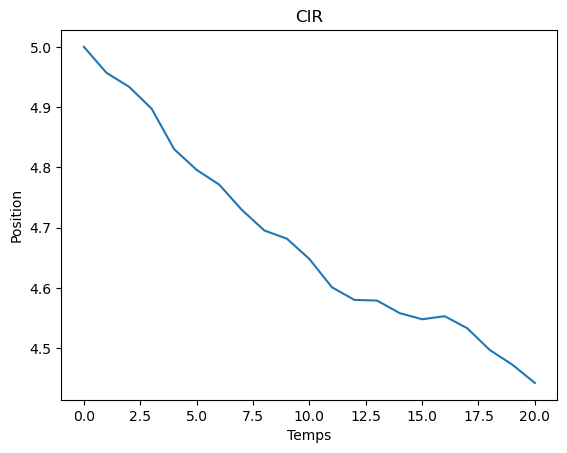

In [6]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR')
plt.show()

In [7]:
nb_samples = 100

In [8]:
M = CIR.multiCIR(alpha, b, sigma, T, k, S_0, nb_samples)

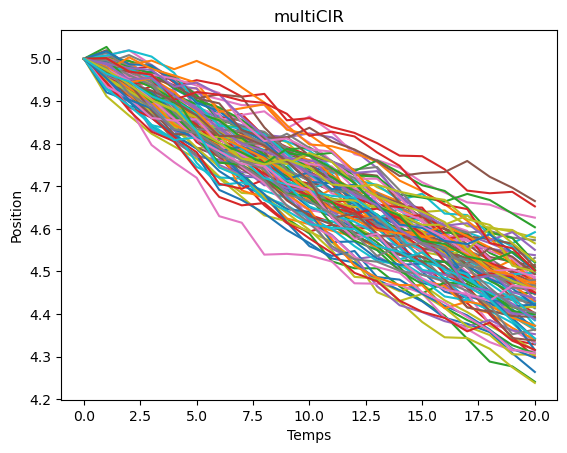

In [9]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# Monte Carlo Ordinaire

In [10]:
import ordinaryMC

In [11]:
ordinaryMC.pv_calc(M[3],r, T)

array([4.75614712, 4.70837888, 4.67567002, 4.69460845, 4.62937152,
       4.61069336, 4.62611389, 4.61789723, 4.57858759, 4.55107964,
       4.50402838, 4.47555292, 4.4177884 , 4.3747912 , 4.35928152,
       4.32218413, 4.29084663, 4.25844729, 4.23566333, 4.21864829,
       4.18712582])

In [12]:
OMC = ordinaryMC.ordinary_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)

In [13]:
np.mean(OMC)

0.6809692747528919

In [14]:
ordinaryMC.sim_iterator(1000, k, S_0, T, r, sigma, K, alpha, b)

array([0.66653888, 0.68702334, 0.67451182, 0.67034021, 0.68223949,
       0.69131059, 0.67375422, 0.67784186, 0.67315367, 0.66996126,
       0.67988382, 0.68217044, 0.68328805, 0.68237865, 0.67913162,
       0.67072154, 0.68137219, 0.67808712, 0.67605954, 0.67845208,
       0.6825572 , 0.6801404 , 0.67946848, 0.68027156, 0.67760889,
       0.67905089, 0.68038926, 0.67985256, 0.68119712, 0.67595235,
       0.68237845, 0.67712884, 0.67479168, 0.68001537, 0.67911222,
       0.67634142, 0.68358329, 0.67866987, 0.67599719, 0.68403653,
       0.67941924, 0.68251957, 0.67888027, 0.67743185, 0.67862704,
       0.67495495, 0.67691955, 0.67669258, 0.67583445, 0.67740411,
       0.67807232, 0.67738877, 0.68503636, 0.68054925, 0.6810168 ,
       0.6803666 , 0.67518629, 0.67848331, 0.6770236 , 0.68189641,
       0.68027067, 0.6766565 , 0.67738459, 0.67781667, 0.67910247,
       0.67886887, 0.67593008, 0.68036457, 0.67797298, 0.68204775,
       0.6779834 , 0.67505884, 0.67450305, 0.68084492, 0.68126

# Quasi Monte Carlo

# tests Multi CIR

In [15]:
L = 20

In [16]:
S = CIR.CIR_ML(alpha, b, sigma, T, k, S_0, L)

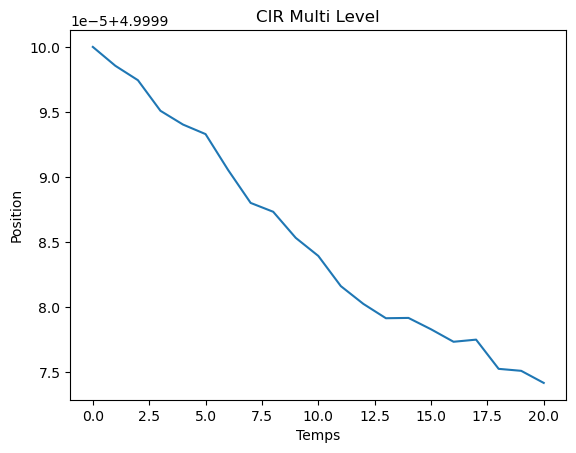

In [17]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [18]:
nb_samples = 100 

In [19]:
M = CIR.multiCIR_ML(alpha, b, sigma, T, k, S_0, nb_samples, L)

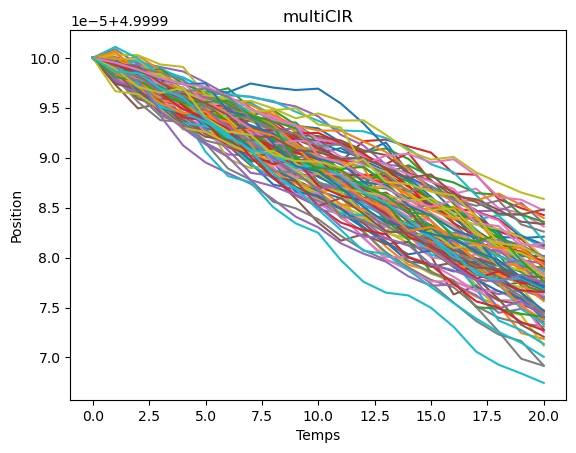

In [20]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# Multi Level Monte Carlo

In [4]:
import MLMC

In [5]:
MLMC_test = MLMC.sim_MLMC(k, S_0, T, r, sigma, K, alpha, b)

KeyboardInterrupt: 